In [1]:
import sys
import os

# Add the src directory to Python path so model.py can find ssn and net modules
sys.path.append(os.path.abspath('../src'))

from src.model import model
from src.model_outerweights import model_outerweights
from src.greedy_insertion import _sample_uniform_sphere_points
from src.training_logger import retrain

import numpy as np
from loguru import logger
import torch

In [2]:
# load the data
path = '../data_result/raw_data/VDP_beta_0.1_grid_combined.npy'# Initialize the weights
data = np.load(path)
logger.info(f"Loaded data with shape: {data.shape}, dtype: {data.dtype}")

2025-09-08 10:26:37.415 | INFO     | __main__:<module>:4 - Loaded data with shape: (1800,), dtype: [('x', '<f8', (2,)), ('dv', '<f8', (2,)), ('v', '<f8')]


In [3]:
# Initialize the parameter
power = 2.1
M = 50 # number greedy insertion selected
num_iterations = 10
loss_weights = (1.0, 0.0)
pruning_threshold = 1e-15

gamma = 5.0
alpha = 1e-5
lr_adam = 1e-5
regularization = (gamma, alpha) 
th = 0.0


In [4]:
# Initialize the model 
model_1 = model(torch.relu, power, regularization, optimizer='Adam', loss_weights = loss_weights)

2025-09-08 10:26:37 | INFO     | src.model:_configure_logger:87 - VDPModel initialized


In [5]:
# prepare the data
data_train, data_valid = model_1._prepare_data(0.8, data)

2025-09-08 10:26:37 | INFO     | src.model:_prepare_data:136 - Training set: 1440 samples, Validation set: 360 samples
2025-09-08 10:26:37 | INFO     | src.model:_prepare_data:139 - Data ranges - x: [-3.00, 3.00], v: [0.00, 10.96], dv: [-13.19, 13.19]


In [6]:
# Set up the initializing weights and bias
init_weights, init_bias = _sample_uniform_sphere_points(M)

In [7]:
model_2 = model_outerweights(torch.relu, power, regularization, optimizer='SSN_TR', loss_weights = loss_weights, th = th)

2025-09-08 10:26:37 | INFO     | src.model_outerweights:_configure_logger:88 - VDPModel (outer weights) initialized


In [8]:
model_result, weight_raw, bias_raw, outerweight_raw = model_1.train(
    data_train=data_train,
    data_valid=data_valid,
    inner_weights=init_weights, 
    inner_bias=init_bias,
    iterations=1000,
    display_every=200,
)
logger.info("Initialization done"); logger.info(f"Initial weights shape: {weight_raw.shape}, bias shape: {bias_raw.shape}")

2025-09-08 10:26:37 | INFO     | src.model:train:255 - Starting network training session
2025-09-08 10:26:37 | INFO     | src.model:_create_network:173 - Creating network with 50 neurons
2025-09-08 10:26:38 | INFO     | src.model:_setup_optimizer:199 - Using Adam optimizer with lr=0.01
2025-09-08 10:26:38 | INFO     | src.model:train:273 - Training model, saving to /Users/ruizhechao/Documents/NNforHJB/train_history
2025-09-08 10:26:38 | INFO     | src.model:train:274 - Training hyperparameters: iterations=1000, batch_size=1620, display_every=200
2025-09-08 10:26:38 | INFO     | src.model:train:275 - Loss weights: value=1.0, gradient=0.0
2025-09-08 10:26:38 | INFO     | src.model:train:320 - Epoch 0: Train Loss = 15.458950, Val Loss = 10.241357
2025-09-08 10:26:39 | INFO     | src.model:train:320 - Epoch 200: Train Loss = 0.133680, Val Loss = 0.120799
2025-09-08 10:26:40 | INFO     | src.model:train:320 - Epoch 400: Train Loss = 0.037234, Val Loss = 0.035111
2025-09-08 10:26:40 | INFO  

In [ ]:
# Training with improved logging
VDP_logger_L2_nc, weight_raw, bias_raw, outerweight_raw = retrain(
    data_train, data_valid, 
    model_1, model_2, model_result, weight_raw, bias_raw, outerweight_raw,
    num_iterations, M, alpha, pruning_threshold, power, gamma
)

logger.info("Training completed with improved logging")

2025-09-08 10:26:41 | INFO     | src.training_logger:retrain:141 - Iteration 0 - weights shape: (50, 2)
2025-09-08 10:26:41 | INFO     | src.model_outerweights:train:251 - Starting network training session (outer weights only)
2025-09-08 10:26:41 | INFO     | src.model_outerweights:_setup_optimizer:188 - Using SSN_TR optimizer with alpha=1e-05, gamma=5.0, th=0.0
2025-09-08 10:26:41 | INFO     | src.model_outerweights:train:267 - Training model, saving to /Users/ruizhechao/Documents/NNforHJB/train_history
2025-09-08 10:26:41 | INFO     | src.model_outerweights:train:268 - Training hyperparameters: iterations=5000, batch_size=1620, display_every=1000
2025-09-08 10:26:41 | INFO     | src.model_outerweights:train:269 - Loss weights: value=1.0, gradient=0.0
2025-09-08 10:26:41 | INFO     | src.model_outerweights:train:314 - Epoch 0: Train Loss = 0.003199, Val Loss = 0.002891
2025-09-08 10:26:57 | INFO     | src.model_outerweights:train:314 - Epoch 1000: Train Loss = 0.003199, Val Loss = 0.0

Reached error 1.71e-4 at 97 neurons

Training run: 10 iterations, max neurons: 263
Using BEST model (lowest validation loss)
Best validation loss: 0.000114
Polar coordinate analysis saved to ../data_result/plot/weights_polar_analysis_best.png


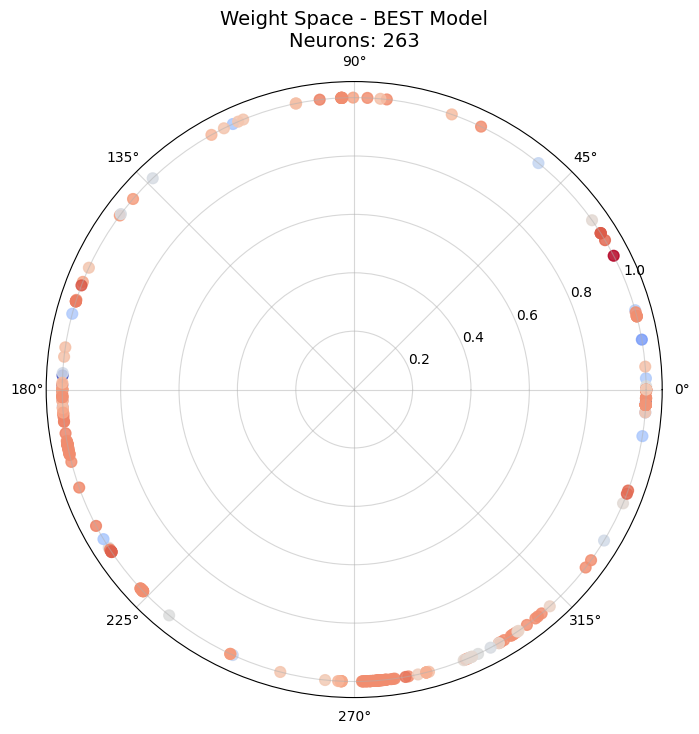

In [ ]:
# =============================================================================
# PLOT: Weight space visualization in polar coordinates
# Shows the distribution of weights in 2D space for the BEST model (lowest validation loss)
# =============================================================================

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract weights from the current training run
weights_run = VDP_logger_L2_nc.history['weights']
biases_run = VDP_logger_L2_nc.history['biases']
neurons_run = VDP_logger_L2_nc.history['neuron_count']

print(f"Training run: {len(weights_run)} iterations, max neurons: {max(neurons_run)}")

# Use the BEST model (lowest validation loss) instead of the iteration with most neurons
print("Using BEST model (lowest validation loss)")
weights_optimal = VDP_logger_L2_nc.history['best_weights']
b_optimal = VDP_logger_L2_nc.history['best_biases'].reshape(1, -1)   # (1, n)
best_loss = VDP_logger_L2_nc.history['best_test_loss']
print(f"Best validation loss: {best_loss:.6f}")

a_optimal = weights_optimal.T                         # (2, n)
Z = a_optimal / (1 + b_optimal) 

# Create polar coordinate visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': 'polar'})

# Compute angles and radii in weight space (2D)
angles = np.arctan2(a_optimal[1], a_optimal[0])
r_sphere = np.sqrt(np.sum(a_optimal**2, axis=0) + (b_optimal.flatten())**2)

# Plot in polar coordinates
radius = np.ones_like(angles)
ax.scatter(angles, radius, c=b_optimal.flatten(), cmap='coolwarm', alpha=0.85, s=60)
ax.set_title(f'Weight Space - BEST Model\nNeurons: {weights_optimal.shape[0]}', fontsize=14)
ax.grid(True, alpha=0.5)

# Save the figure
plt.savefig('../data_result/plot/weights_polar_analysis_best.png', dpi=300, bbox_inches='tight')
print(f"Polar coordinate analysis saved to ../data_result/plot/weights_polar_analysis_best.png")

# Show plot
plt.show()

## Test with the L1 Penalty ##

In [11]:
# Initialize the parameter
power = 2.1
M = 50 # number greedy insertion selected
num_iterations = 10
loss_weights = (1.0, 0.0)
pruning_threshold = 1e-13

gamma = 1e-10
alpha = 1e-5
regularization = (gamma, alpha) 
th = 1.0

The comparable model is about: 207 neurons

In [ ]:
# Initialize the model 
model_1 = model(torch.relu, power, regularization, optimizer='Adam', loss_weights = loss_weights)
model_2 = model_outerweights(torch.relu, power, regularization, optimizer='SSN_TR', loss_weights = loss_weights, th = th)

# Prepare data
data_train, data_valid = model_1._prepare_data(0.8, data)

# Set up the initializing weights and bias
init_weights = np.random.randn(M, 2) * 0.1
init_bias = np.random.randn(M)

model_result, weight_raw, bias_raw, outerweight_raw = model_1.train(
    data_train=data_train,
    data_valid=data_valid,
    inner_weights=init_weights, 
    inner_bias=init_bias,
    iterations=1000,
    display_every=200,
)
logger.info("Initialization done"); logger.info(f"Initial weights shape: {weight_raw.shape}, bias shape: {bias_raw.shape}")

# Training with improved logging
VDP_logger_L2_lasso, weight_raw_1, bias_raw_1, outerweight_raw_1 = retrain(
    data_train, data_valid, model_1, model_2, model_result, weight_raw, bias_raw, outerweight_raw,
    num_iterations, M, alpha, pruning_threshold, power, gamma
)

logger.info("Training completed with improved logging")


2025-09-08 11:46:02 | INFO     | src.model:_configure_logger:87 - VDPModel initialized
2025-09-08 11:46:02 | INFO     | src.model_outerweights:_configure_logger:88 - VDPModel (outer weights) initialized
2025-09-08 11:46:02 | INFO     | src.model:_prepare_data:136 - Training set: 1440 samples, Validation set: 360 samples
2025-09-08 11:46:02 | INFO     | src.model:_prepare_data:139 - Data ranges - x: [-3.00, 3.00], v: [0.00, 10.96], dv: [-13.19, 13.19]
2025-09-08 11:46:02 | INFO     | src.model:train:255 - Starting network training session
2025-09-08 11:46:02 | INFO     | src.model:_create_network:173 - Creating network with 50 neurons
2025-09-08 11:46:02 | INFO     | src.model:_setup_optimizer:199 - Using Adam optimizer with lr=0.01
2025-09-08 11:46:02 | INFO     | src.model:train:273 - Training model, saving to /Users/ruizhechao/Documents/NNforHJB/train_history
2025-09-08 11:46:02 | INFO     | src.model:train:274 - Training hyperparameters: iterations=1000, batch_size=1620, display_eve

Reached 2.3e-4 at 131 neurones
Reached 1.96e-4 at 213 neurones

Training run: 10 iterations, max neurons: 244
Using BEST model (lowest validation loss)
Best validation loss: 0.000139


Polar coordinate analysis saved to ../data_result/plot/weights_polar_analysis_best_l1.png


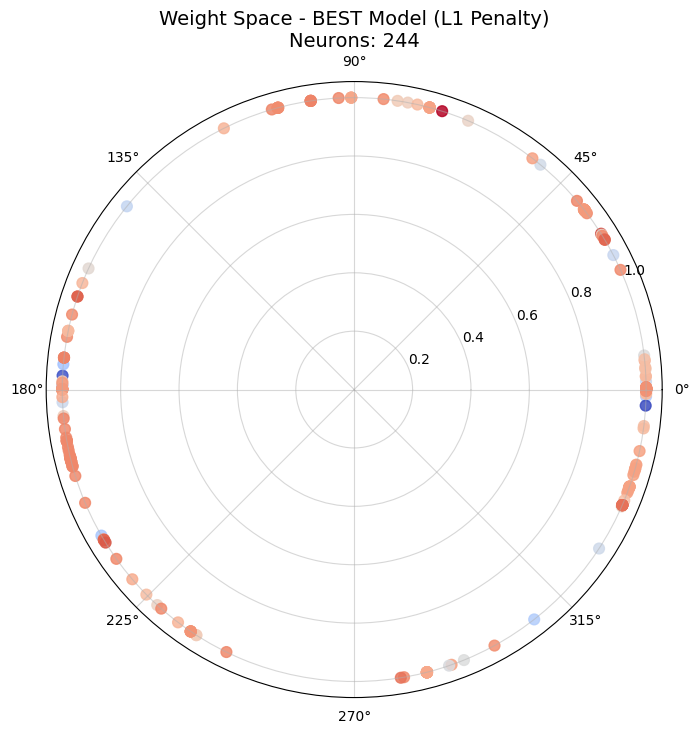


=== Weight Evolution ===
Neuron counts across iterations:
Iteration 0: 81 neurons
Iteration 1: 131 neurons
Iteration 2: 181 neurons
Iteration 3: 213 neurons
Iteration 4: 237 neurons
Iteration 5: 243 neurons
Iteration 6: 237 neurons
Iteration 7: 236 neurons
Iteration 8: 244 neurons
Iteration 9: 214 neurons


In [ ]:
# =============================================================================
# PLOT: Weight space visualization in polar coordinates
# Shows the distribution of weights in 2D space for the BEST model (lowest validation loss)
# =============================================================================

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract weights from the current training run
weights_run = VDP_logger_L2_lasso.history['weights']
biases_run = VDP_logger_L2_lasso.history['biases']
neurons_run = VDP_logger_L2_lasso.history['neuron_count']

print(f"Training run: {len(weights_run)} iterations, max neurons: {max(neurons_run)}")

# Use the BEST model (lowest validation loss) instead of the iteration with most neurons
if 'best_weights' in VDP_logger_L2_lasso.history:
    print("Using BEST model (lowest validation loss)")
weights_optimal = VDP_logger_L2_lasso.history['best_weights']
b_optimal = VDP_logger_L2_lasso.history['best_biases'].reshape(1, -1)   # (1, n)
best_loss = VDP_logger_L2_lasso.history['best_test_loss']
print(f"Best validation loss: {best_loss:.6f}")

a_optimal = weights_optimal.T                         # (2, n)
Z = a_optimal / (1 + b_optimal) 

# Create polar coordinate visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8), subplot_kw={'projection': 'polar'})

# Compute angles and radii in weight space (2D)
angles = np.arctan2(a_optimal[1], a_optimal[0])
r_sphere = np.sqrt(np.sum(a_optimal**2, axis=0) + (b_optimal.flatten())**2)

# Plot in polar coordinates
radius = np.ones_like(angles)
ax.scatter(angles, radius, c=b_optimal.flatten(), cmap='coolwarm', alpha=0.85, s=60)
ax.set_title(f'Weight Space - BEST Model (L1 Penalty)\nNeurons: {weights_optimal.shape[0]}', fontsize=14)
ax.grid(True, alpha=0.5)

# Save the figure
plt.savefig('../data_result/plot/weights_polar_analysis_best_l1.png', dpi=300, bbox_inches='tight')
print(f"Polar coordinate analysis saved to ../data_result/plot/weights_polar_analysis_best_l1.png")

# Show plot
plt.show()


# Optional: Show weight evolution across iterations
if len(weights_run) > 1:
    print(f"\n=== Weight Evolution ===")
    print("Neuron counts across iterations:")
    for i, count in enumerate(neurons_run):
        print(f"Iteration {i}: {count} neurons")